In [1]:
%matplotlib inline
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append('..')
from util import add_angles, angle_between, angled_vector

In [2]:
def get_rotation_matrix(angle):
    c = np.cos(angle)
    s = np.sin(angle)
    R = np.array([c, -s, s, c]).reshape(2,2)
    return R

In [3]:
R = get_rotation_matrix(np.deg2rad(270))
R @ np.array([1,0])

array([ -1.83697020e-16,  -1.00000000e+00])

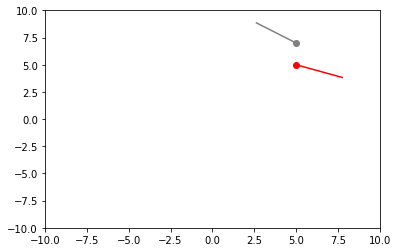

In [4]:
def plot_grid(p1, p2, traj1, traj2):
    fig, ax = plt.subplots()
    ax.scatter(p1[0], p1[1], c='r')
    ax.scatter(p2[0], p2[1], c='gray')

    ax.plot([p1[0], p1[0] + traj1[0]], [p1[1], p1[1] + traj1[1]], c='r')
    ax.plot([p2[0], p2[0] + traj2[0]], [p2[1], p2[1] + traj2[1]], c='gray')

    ax.set_xbound(-10, 10)
    ax.set_ybound(-10, 10)
    

pos1, pos2 = np.array([5,5]), np.array([5,7])
ang1, ang2 = np.deg2rad([-23, 142])
traj1, traj2 = angled_vector(ang1) * 3, angled_vector(ang2) * 3

plot_grid(pos1, pos2, traj1, traj2)

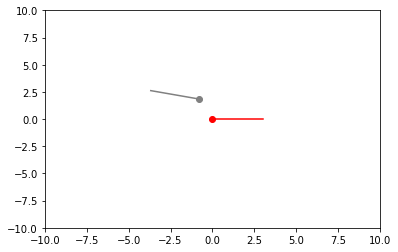

In [5]:
# RF
# 1. Rotate coord system.
R = get_rotation_matrix(-ang1)
pos1_rot = R @ pos1.reshape(2,1)
pos2_rot = R @ pos2.reshape(2,1)
traj1_rot = R @ traj1
traj2_rot = R @ traj2
# 2. Set p1 at center (0,0) and adjust other
pos2_rot -= pos1_rot
pos1_rot = np.array([0.0, 0.0])
ang1_rot = 0.0
ang2_rot = ang2 - ang1
# 3. Plot
plot_grid(pos1_rot, pos2_rot, traj1_rot, traj2_rot)

In [6]:
traj2

array([-2.36403226,  1.84698443])

In [7]:
np.rad2deg(angle_between(np.array([1,0]), traj2_rot))

165.0

In [8]:
np.rad2deg(ang2_rot)

165.0